In [50]:
# Imports

from core.controllers import FBLinController, LQRController, PDController
from core.dynamics import FBLinDynamics, SystemDynamics
from core.systems import PlanarQuadrotor
from matplotlib.pyplot import cla, clf, figure, grid, legend, plot, show, subplot, xlabel, ylabel
from numpy import array, concatenate, cos, identity, linspace, sin, zeros

In [51]:
# Extended Quadrotor System Definition

class ExtendedPlanarQuadrotor(SystemDynamics):
    def __init__(self, planar_quadrotor):
        SystemDynamics.__init__(self,8,2)
        self.dynamics = planar_quadrotor
        
    def step(self, x_0, u_0, t_0, t_f, atol=1e-6, rtol=1e-6):
        """Simulate system from initial state with constant action over a
        time interval. Update force estimates with Euler numerical integration
        
        Approximated using Runge-Kutta 4,5 solver.
        
        Inputs:
        Initial state, x_0: numpy array
        Control action, u_0: numpy array
        Initial time, t_0: float
        Final time, t_f: float
        Absolute tolerance, atol: float
        Relative tolerance, rtol: float
        
        Outputs:
        State at final time: numpy array
        """
        x_cont = x_0[0:6]
        f_t = x_0[6]
        f_t_dot = x_0[7]
        u_cont = array([f_t, u_0[1]])
        delta_t = t_f - t_0
        
        x_cont = self.dynamics.step(x_cont, u_cont, t_0, t_f, atol, rtol)
        f_t = f_t + f_t_dot * (delta_t)
        f_t_dot = f_t_dot + u_0[0] * (delta_t)
        
        return concatenate([x_cont, array([f_t, f_t_dot])])



In [52]:
# Extended Quadrotor Output Definition

class ExtendedPlanarQuadrotorOutput(FBLinDynamics):
    def __init__(self, extended_quadrotor):
        FBLinDynamics.__init__(self, array([4, 4]))
        self.ex_quad = extended_quadrotor
        self.quad = self.ex_quad.dynamics
        self.params = self.quad.params
    
    def x_ddot(self, x, t):
        m, _, _ = self.params
        _, _, theta, _, _, _, f_t, _ = x
        
        return (1 / m) * (-sin(theta) * f_t)
        
    def z_ddot(self, x, t):
        m, _, g = self.params
        _, _, theta, _, _, _, f_t, _ = x
    
        return -g + (1 / m) * (cos(theta) * f_t)  
    
    def x_dddot(self, x, t):
        m, _, _ = self.params
        _, _, theta, _, _, theta_dot, f_t, f_t_dot = x
        
        return (1 / m) * (-cos(theta) * theta_dot * f_t - sin(theta) * f_t_dot)
        
    def z_dddot(self, x, t):
        m, _, _ = self.params
        _, _, theta, _, _, theta_dot, f_t, f_t_dot = x
    
        return (1 / m) * (-sin(theta) * theta_dot * f_t + cos(theta) * f_t_dot)    
        
    
    def eval(self, x, t):
        x_ddot  = self.x_ddot(x, t)
        z_ddot  = self.z_ddot(x, t)
        x_dddot = self.x_dddot(x, t)
        z_dddot = self.z_dddot(x, t)
        
        return array([x[0], x[3], x_ddot, x_dddot, x[1], x[4], z_ddot, z_dddot])
            
            
    def drift(self, x, t):
        _, _, theta, x_dot, z_dot, theta_dot, f_t, f_t_dot = x
        x_ddot  = self.x_ddot(x, t)
        z_ddot  = self.z_ddot(x, t)
        x_dddot = self.x_dddot(x, t)
        z_dddot = self.z_dddot(x, t)
        m, _, _ = self.params
        
        x_ddddot_drift = sin(theta) * theta_dot ** 2 - 2 * cos(theta) * theta_dot * f_t_dot
        z_ddddot_drift = -cos(theta) * theta_dot ** 2 - 2 * sin(theta) * theta_dot * f_t_dot
        
        return array([x_dot, x_ddot, x_dddot, (x_ddddot_drift / m), z_dot, z_ddot, z_dddot, (z_ddddot_drift / m)])
    
    def act(self, x, t):
        _, _, theta, _, _, _, f_t, _ = x
        m, J, _ = self.params
        
        act_x = array([[-sin(theta), -f_t * cos(theta) / J]])
        act_z = array([[cos(theta), -f_t * sin(theta) / J]])
        
        return concatenate([zeros((3,2)), act_x, zeros((3,2)), act_z])
        

In [112]:
# System Definitions
m = 2
g = 9.81
J = 1
m_true = 0.9*m
J_true = 0.9*J

quad = PlanarQuadrotor(m, J)
quad_true = PlanarQuadrotor(m_true, J_true)
ex_quad = ExtendedPlanarQuadrotor(quad)
ex_quad_true = ExtendedPlanarQuadrotor(quad_true)
ex_quad_output = ExtendedPlanarQuadrotorOutput(ex_quad)

In [113]:
# Controller Definition
Q = 200 * identity(8)
R = identity(2)
lqr = LQRController.build(ex_quad_output, Q, R)
fb_lin = FBLinController(ex_quad_output, lqr)

In [114]:
# PD 400 Hz Simulation
freq = 400 # Hz
tend = 20

x_0 = array([2, 2, 0, 0, 0, 0, m * g, 0])
ts_fblin = linspace(0, tend, tend*freq + 1)
fblin_data = ex_quad_true.simulate(x_0, fb_lin, ts_fblin)
xs_fblin, us_fblin = fblin_data


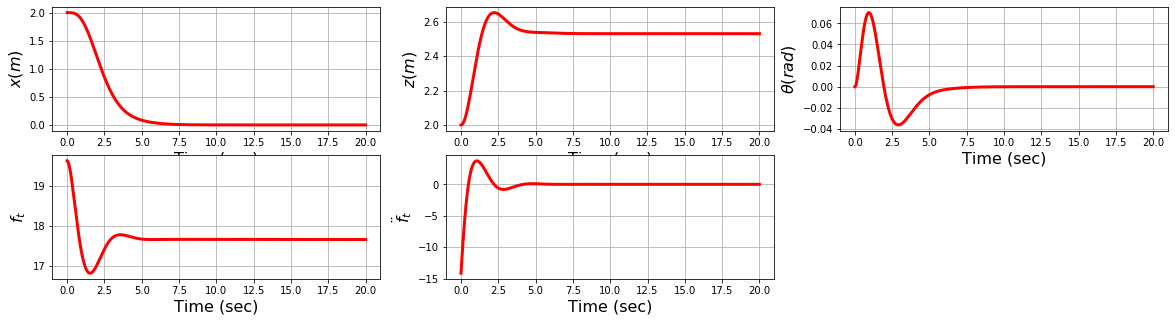

In [115]:
# PLATS

figure(figsize=(20, 5))

subplot(231)
plot(ts_fblin, xs_fblin[:, 0], 'r', linewidth=3)
grid()
xlabel('Time (sec)', fontsize=16)
ylabel('$x (m)$', fontsize=16)

subplot(232)
plot(ts_fblin, xs_fblin[:, 1], 'r', linewidth=3)
grid()
xlabel('Time (sec)', fontsize=16)
ylabel('$z (m)$', fontsize=16)

subplot(233)
plot(ts_fblin, xs_fblin[:, 2], 'r', linewidth=3)
grid()
xlabel('Time (sec)', fontsize=16)
ylabel('$\\theta (rad)$', fontsize=16)

subplot(234)
plot(ts_fblin, xs_fblin[:, 6], 'r', linewidth=3)
grid()
xlabel('Time (sec)', fontsize=16)
ylabel('$f_t$', fontsize=16)

subplot(235)
plot(ts_fblin[:-1], us_fblin[:, 0], 'r', linewidth=3)
grid()
xlabel('Time (sec)', fontsize=16)
ylabel('$\\ddot{f}_t$', fontsize=16)


show()